# Stability at the 12m tower

__Problem Statement__:
Stability is normally estimated using at most a handful of point observations. With DTS we can continuously define the gradient using very fine resolution temperature observations. What meteorological conditions impact the stability? Here we will investigate stability defined as $\frac{dT}{d\ln{z}}$ using the tower DTS Bayesian GLM with student's t-distribution priors for the DTS error.

__Goals of Notebook__:
- Understand which conditions lead to different classifications of stability (
- Understand how that varies with estimate type.
- Investigate the factors that contribute to the largest disagreements between CSAT observed sensible heat flux and the DTS observed stability.

DTS stability were estimated using a log-linear Bayes GLM assuming that errors were distributed as Student's t distributions. These inferences were made in `bayesian-GLM_estimate-dTdz.ipynb`

# 1. Import and formatting

In [1]:
# Data and methods libraries
import numpy as np
import xarray as xr
import scipy.stats
import pandas as pd

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import copy
import warnings
import itertools

# Clustering/dimensionality reduction
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

## Format plots

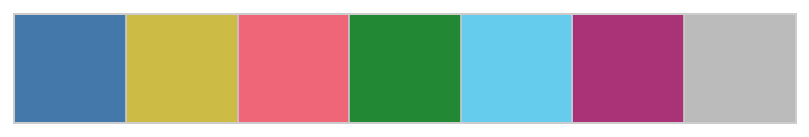

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = ['#4477AA', '#CCBB44', '#EE6677', '#228833', '#66CCEE', '#AA3377', '#BBBBBB']
sns.set_palette(sns.color_palette(tol_bright_reorder))
sns.palplot(tol_bright_reorder)

## Directories

In [3]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/')

# Met data
dir_logger_data = os.path.join(dir_pre, 'logger_data')
dir_aws_data = os.path.join(dir_logger_data, 'AWS')
dir_csat_stats = os.path.join(dir_logger_data, 'CSATs', 'stats')
dir_csat_flux = os.path.join(dir_logger_data, 'CSATs', 'fluxes')
dir_csat_corr = os.path.join(dir_logger_data, 'CSATs', 'csat-Ts-correction')
dir_ceil = os.path.join(dir_pre, 'love_dts/ESSD-repository/remote-sensing/ceilometer/')
dir_press = os.path.join(dir_logger_data, 'pressure')
dir_bayes_glm = os.path.join(dir_pre, 'love_dts', 'bayes_glm')
dir_homogenized_data = os.path.join(dir_pre, 'homogenized_data')

# Figures
dir_print = os.path.join(dir_pre, 'figures', 'AncillaryMet')


# 2. Load data

## 2.1 Homogenized data

Use the homogenized data from `homogenizing-stability-data.ipynb`

In [4]:
os.chdir(dir_homogenized_data)

sonic_1min = xr.open_dataset('sonics_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')
sonic_10min = xr.open_dataset('sonics_pot-temp_10min_qc_tower-subset.v1-2021-02-22.nc')
aws_2m_theta = xr.open_dataarray('aws_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')
aws_2m_theta_10min = xr.open_dataarray('aws_pot-temp_10min_qc_tower-subset.v1-2021-02-22.nc')
tower = xr.open_dataset('tower_pot-temp_1s_qc_tower-subset.v1-2021-02-22.nc')
tower_1min = xr.open_dataset('tower_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')


## 2.2 Tower 10min Bayesian modeling output

In [5]:
os.chdir(dir_bayes_glm)
tower_10min = xr.open_dataset('tower_10min_bayes_glm.nc')

## 2.2 Ceilometer, AWS, and pressure data

- Ceilometer for cloudiness
- AWS for radiation and RH
- pressure for potential temperature calculations

In [6]:
os.chdir(dir_ceil)
ceilo = xr.open_dataset('ceiolometer-combined-files_2019_June01-Aug15.nc')
ceilo = ceilo.reindex_like(sonic_1min.time, method='nearest')
ceilo_10min = ceilo.interp_like(tower_10min.time, method='nearest')

In [7]:
os.chdir(dir_aws_data)
aws_10min = xr.open_dataset('AWS_Voi_10min.nc')

## 2.3 Quickly estimate stability using the CSATs

In [8]:
sonic_10min['ols_m'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_r'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_p'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_b'] = (('time'), np.zeros(len(sonic_10min.time.values)))


In [9]:
for t in sonic_10min.time:
    ds = sonic_10min.sel(time=t).theta

    result_dts = scipy.stats.linregress(np.log(ds.z), ds.values)
    sonic_10min['ols_m'].loc[{'time': t}] = result_dts.slope
    sonic_10min['ols_r'].loc[{'time': t}] = result_dts.rvalue
    sonic_10min['ols_p'].loc[{'time': t}] = result_dts.pvalue
    sonic_10min['ols_b'].loc[{'time': t}] = result_dts.intercept

## 2.4 Create a gappy version of the 10min DTS tower data

In [10]:
dt = pd.date_range(
    start=pd.Timestamp(tower_10min.time[0].values),
    end=pd.Timestamp(tower_10min.time[-1].values),
    freq='10min',
)

tower_10min_nanfill = tower_10min.reindex(time=dt, tolerance=1, method='nearest')

# 3. Visualize distribution of the stability

## 3.1 Simple histograms classified by approximate time of day

Text(0, 0.5, 'Counts (-)')

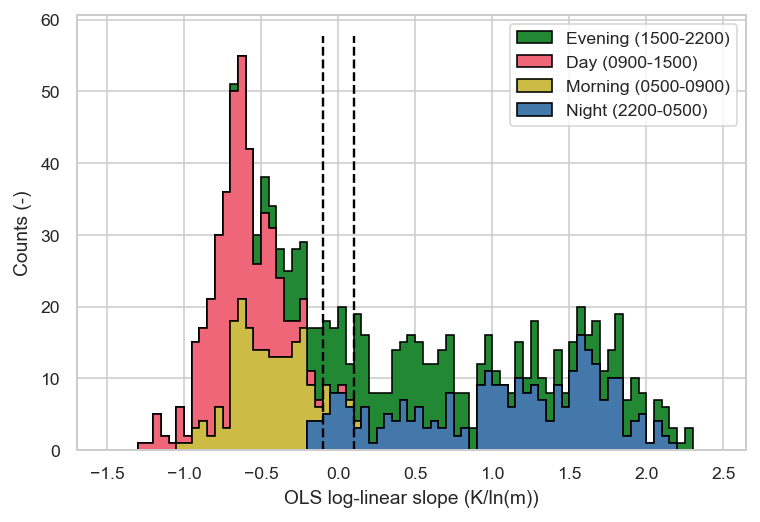

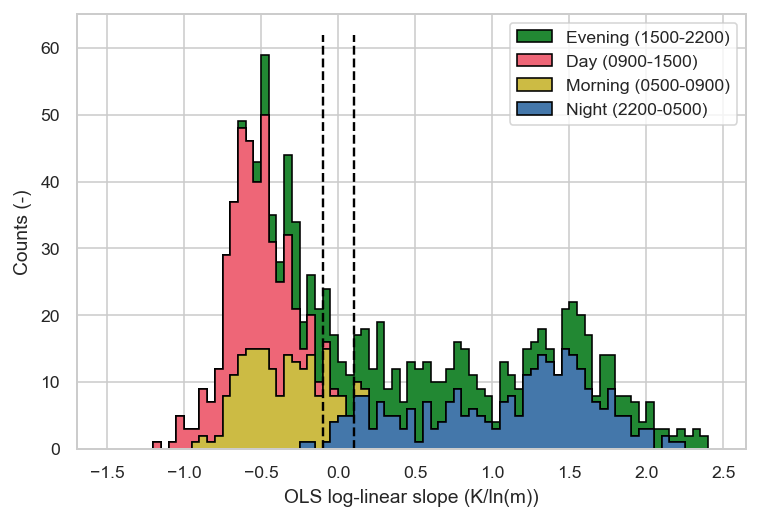

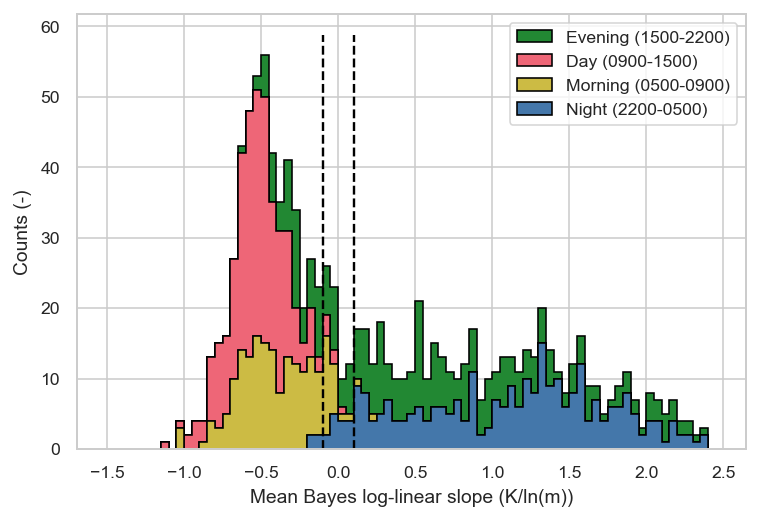

In [11]:
# OLS linear fit
plt.figure()
ds = sonic_10min.ols_m
plt.hist([
    ds.where((ds['time.hour'] < 5) | (ds['time.hour'] > 22)),
    ds.where((ds['time.hour'] >= 5) & (ds['time.hour'] < 9)),
    ds.where((ds['time.hour'] >= 9) & (ds['time.hour'] < 15)),
    ds.where((ds['time.hour'] >= 15) & (ds['time.hour'] < 22)),
    ], 
    np.arange(-1.5, 2.5, 0.05),
    stacked=True,
    histtype='stepfilled',
    label=[
        'Night (2200-0500)',
        'Morning (0500-0900)',
        'Day (0900-1500)',
        'Evening (1500-2200)',
    ],
    edgecolor='k'
);
plt.legend()
ymax = plt.gca().get_ylim()[-1]
plt.plot([-0.1, -0.1], [0, ymax], 'k--')
plt.plot([0.1, 0.1], [0, ymax], 'k--')
plt.gca().set_xlabel('OLS log-linear slope (K/ln(m))')
plt.gca().set_ylabel('Counts (-)')


# OLS linear fit
plt.figure()
ds = tower_10min.ols_m
plt.hist([
    ds.where((ds['time.hour'] < 5) | (ds['time.hour'] > 22)),
    ds.where((ds['time.hour'] >= 5) & (ds['time.hour'] < 9)),
    ds.where((ds['time.hour'] >= 9) & (ds['time.hour'] < 15)),
    ds.where((ds['time.hour'] >= 15) & (ds['time.hour'] < 22)),
    ], 
    np.arange(-1.5, 2.5, 0.05),
    stacked=True,
    histtype='stepfilled',
    label=[
        'Night (2200-0500)',
        'Morning (0500-0900)',
        'Day (0900-1500)',
        'Evening (1500-2200)',
    ],
    edgecolor='k',
);
plt.legend()
ymax = plt.gca().get_ylim()[-1]
plt.plot([-0.1, -0.1], [0, ymax], 'k--')
plt.plot([0.1, 0.1], [0, ymax], 'k--')
plt.gca().set_xlabel('OLS log-linear slope (K/ln(m))')
plt.gca().set_ylabel('Counts (-)')

# Student's t-distribution
plt.figure()
ds = tower_10min.b1_slope.mean(dim='draws')
plt.hist([
    ds.where((ds['time.hour'] < 5) | (ds['time.hour'] > 22)),
    ds.where((ds['time.hour'] >= 5) & (ds['time.hour'] < 9)),
    ds.where((ds['time.hour'] >= 9) & (ds['time.hour'] < 15)),
    ds.where((ds['time.hour'] >= 15) & (ds['time.hour'] < 22)),
    ], 
    np.arange(-1.5, 2.5, 0.05),
    stacked=True,
    histtype='stepfilled',
    label=[
        'Night (2200-0500)',
        'Morning (0500-0900)',
        'Day (0900-1500)',
        'Evening (1500-2200)',
    ],
    edgecolor='k',
);
plt.legend()
ymax = plt.gca().get_ylim()[-1]
plt.plot([-0.1, -0.1], [0, ymax], 'k--')
plt.plot([0.1, 0.1], [0, ymax], 'k--')
plt.gca().set_xlabel('Mean Bayes log-linear slope (K/ln(m))')
plt.gca().set_ylabel('Counts (-)')

## 3.2 Visualizing the distribution of slopes during neutral conditions

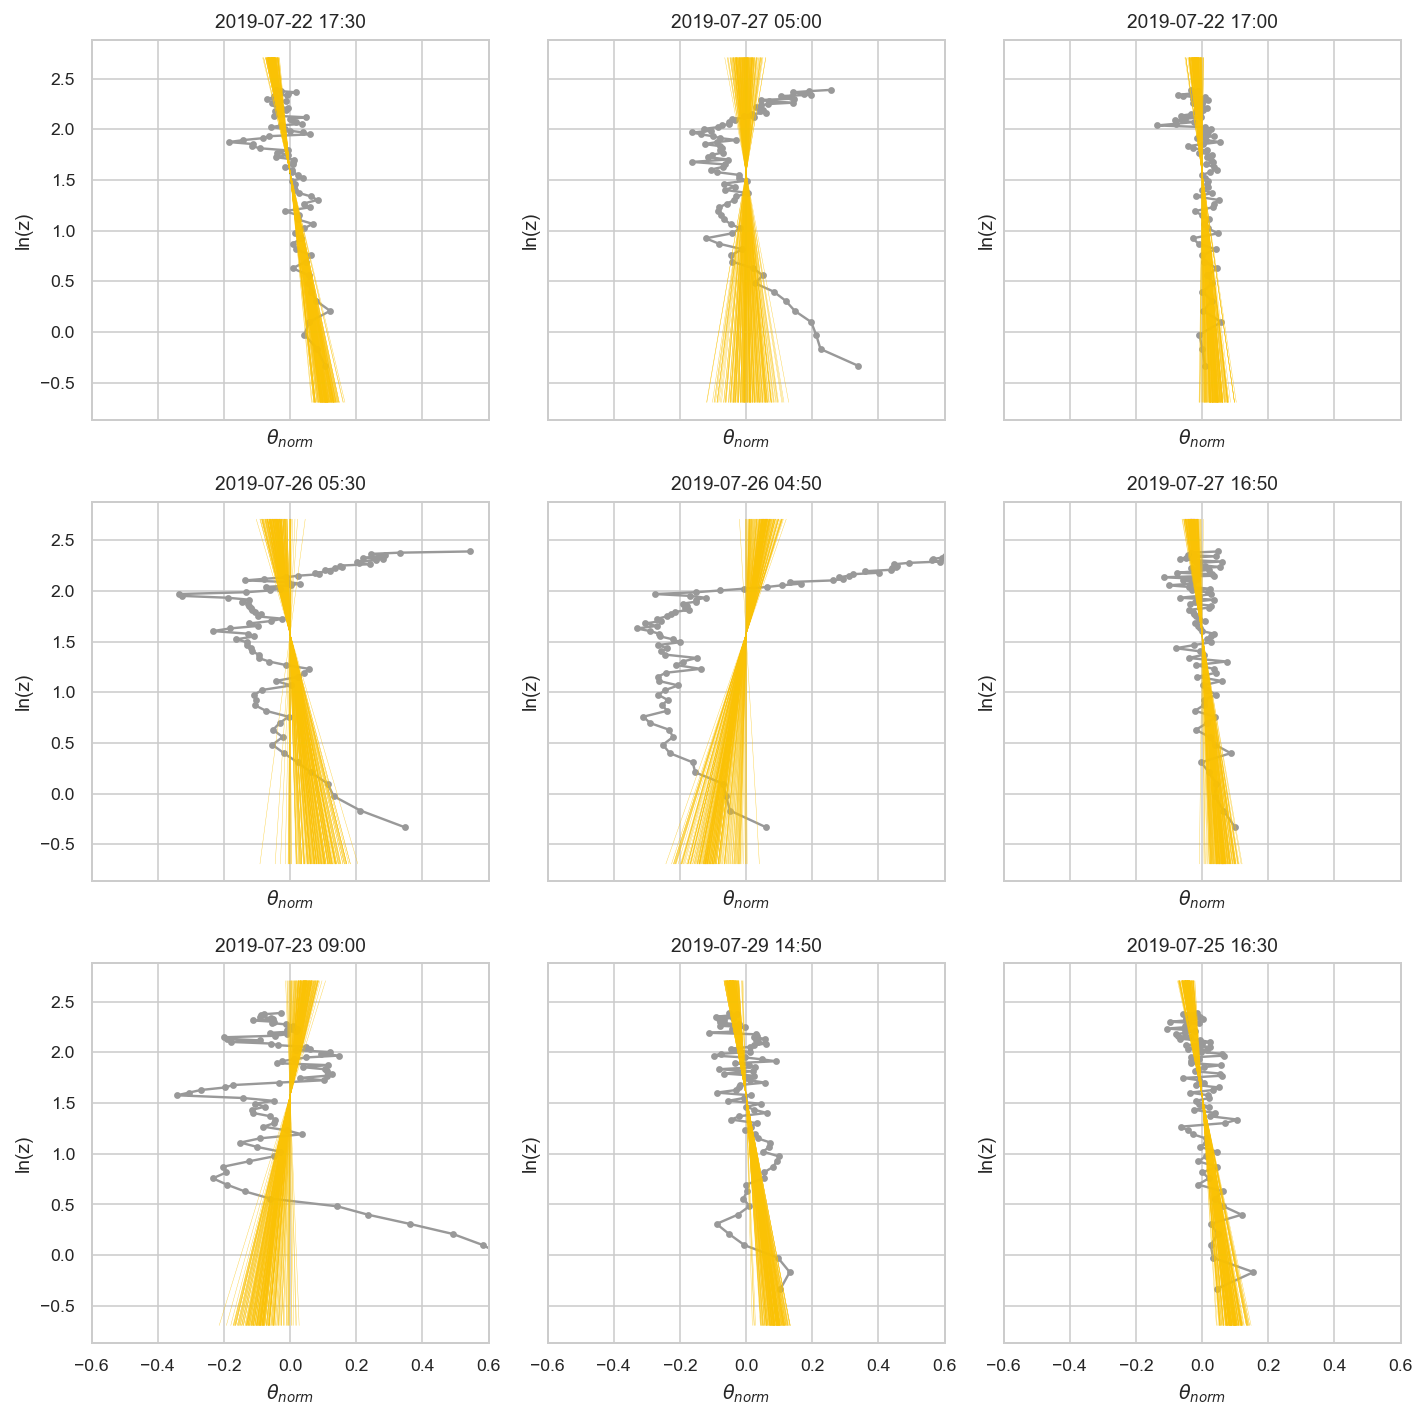

In [12]:
from numpy.random import default_rng

ind = (tower_10min.b1_slope.mean(dim='draws') < 0.05) & (tower_10min.b1_slope.mean(dim='draws') > -0.05)
ds = tower_10min.where(ind, drop=True)

rng = default_rng()
samp = rng.choice(len(ds.time.values), size=9, replace=False)

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(10, 10))
axes = axes.flatten()

lm = lambda x, s: s["b0_intercept"].values + s["b1_slope"].values * x
lnz_eval = np.arange(np.log(0.5), np.log(15), 0.01)
lnz_normalize = ds.lnz.values
for ns, n in enumerate(samp):
    ax = axes[ns]
    dt = pd.Timestamp(ds.isel(time=n).time.values)
    ds_dt = ds.isel(time=n)
    y = ds_dt.lnz.values
    x = ds_dt.theta_mean_norm.values
    ax.plot(x, y, color='0.6', marker='.')

    for rand_loc in np.random.randint(0, len(tower_10min.draws), 200):
        rand_sample = ds.isel(time=n).isel(draws=rand_loc)
        ax.plot(
            lm(lnz_eval, rand_sample) - np.mean(lm(lnz_normalize, rand_sample)),
            lnz_eval,
            color='xkcd:goldenrod',
            alpha=0.8,
            lw=0.2,
        )
        
    ax.plot(
        ds.ols_b.isel(time=n).values + ds.ols_m.isel(time=n).values * lnz_eval,
        lnz_eval,
        color='k', lw=0.8, ls='--')
    
    ax.set_title(dt.strftime('%Y-%m-%d %H:%M'))
    ax.set_ylabel('ln(z)')
    ax.set_xlabel(r'$\theta_{norm}$')
    ax.set_xlim(-0.6, 0.6)
fig.tight_layout()

Periods with obvious sublayers are still fairly poorly fit. But in general this gives the results I would intuitively expect. This definitely highlights the dangers of using a bulk stability estimate instead of locally defined stability estimates. That is a good direction for future inquiry.

# 4. Explain what drives the stability

## 4.1 Massage the data into pandas

Seaborn plays nicely with pandas and seaborn is an easy way to quickly visualize a large number of relationships.

In [13]:
ds = copy.deepcopy(tower_10min)
ds['interval'] = (('time'), np.zeros_like(ds.ols_m))
ds['interval'] = ds['interval'].where((ds['time.hour'] > 4) & (ds['time.hour'] <= 22), 'night')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 4) | (ds['time.hour'] >= 9), 'morning')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 9) | (ds['time.hour'] >= 15), 'day')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 15) | (ds['time.hour'] > 22), 'evening')

Then convert everything to pandas.

In [14]:
# Create a merged Dataset.
# Previously I worked with just the 4m CSAT. Here I include all of them for additional
# investigation.
ds_10min = xr.merge(
    [
        sonic_10min.theta,
        sonic_10min.wTs,
        sonic_10min.U_scalar_mean_rot.rename('U_sonic'),
        tower_10min.b1_slope.mean(dim='draws'),
        ceilo_10min.tcc,
        aws_2m_theta_10min.rename('AWS_theta_2m'),
        aws_10min['Rlwd (CNR4)'].rename('LWdwn'),
        (aws_10min['Rlwd (CNR4)'] - aws_10min['Rlwu (CNR4)']).rename('LWnet'),
        aws_10min['Rswd (CNR4)'].rename('SWdwn'),
        ds['interval'],
    ],
)

df_10min = xr.Dataset.to_dataframe(
    ds_10min.drop(
        [
            'x', 'z', 'LAF',
            'northcones', 'unheated',
            'southcones', 'y',
            'heated', 'eastcones'
        ],
    errors='ignore',
    )
)

## 4.2 Stability vs radiation and turbulence terms

Broken down by time of day.

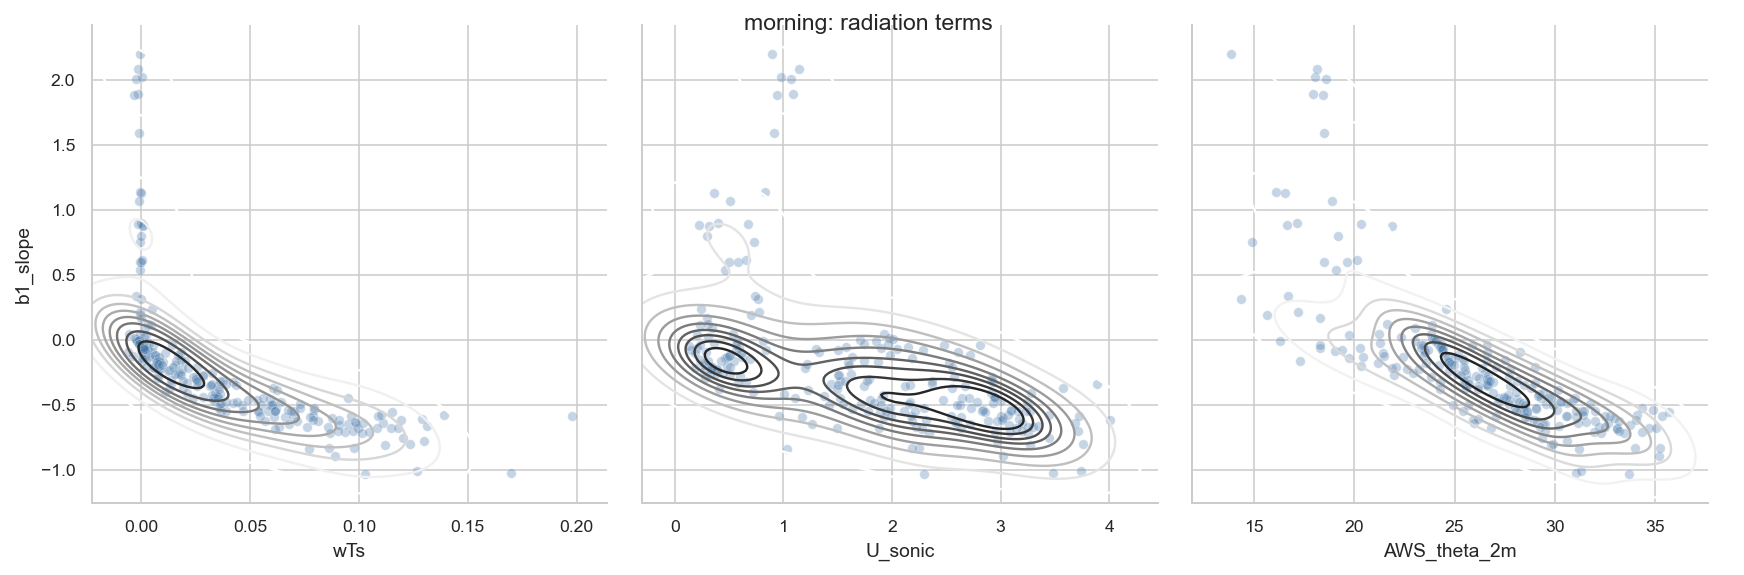

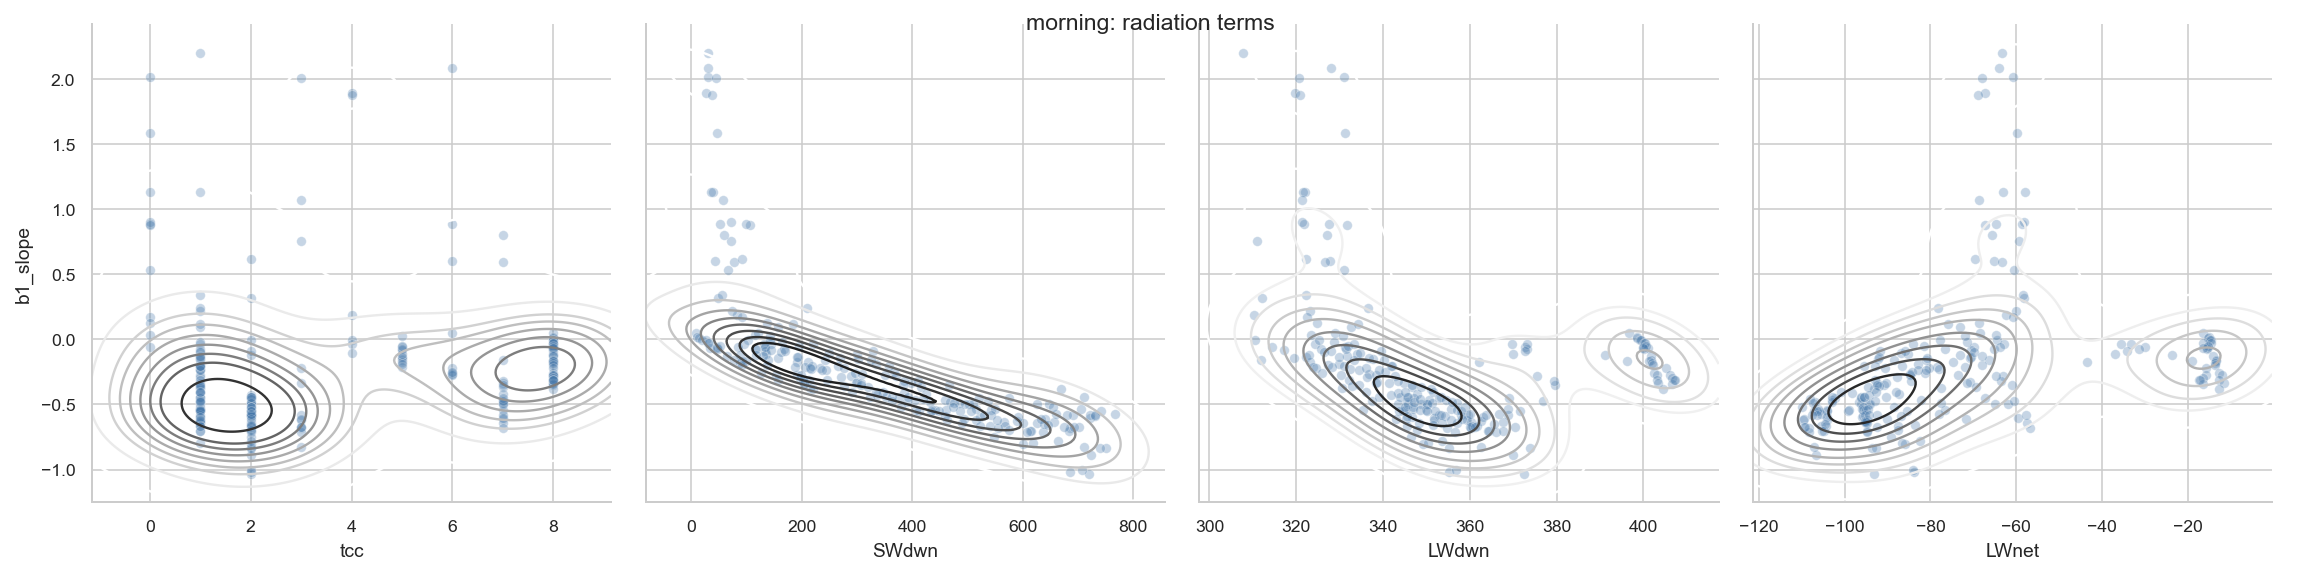

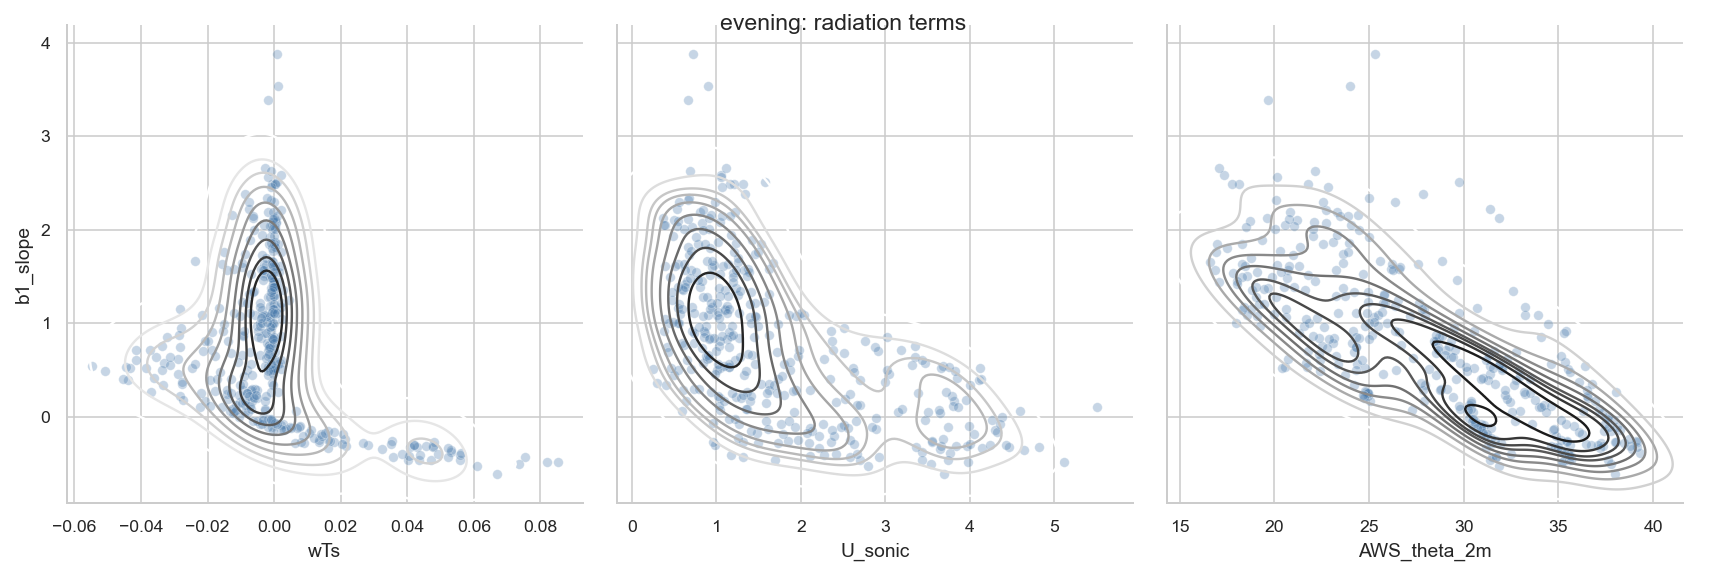

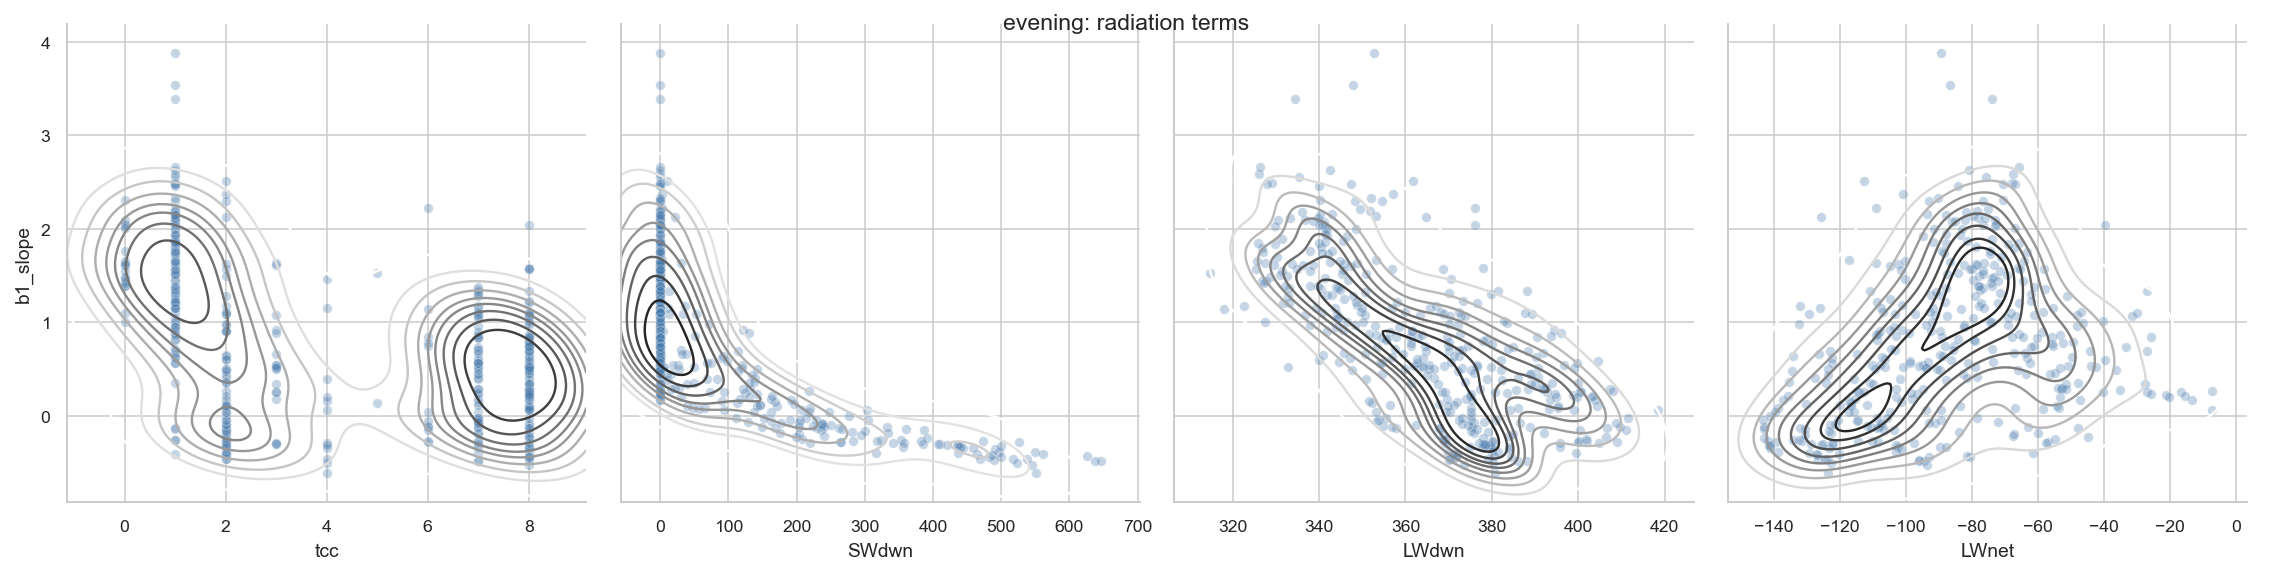

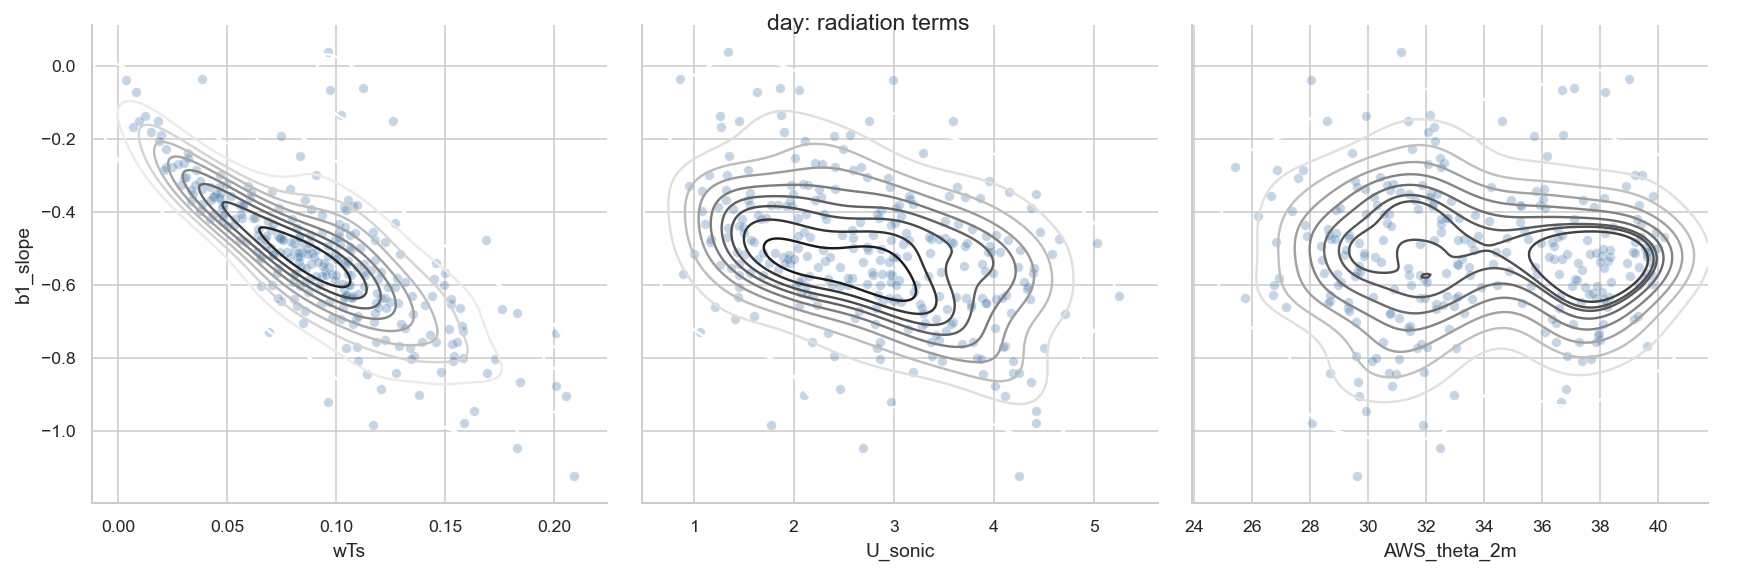

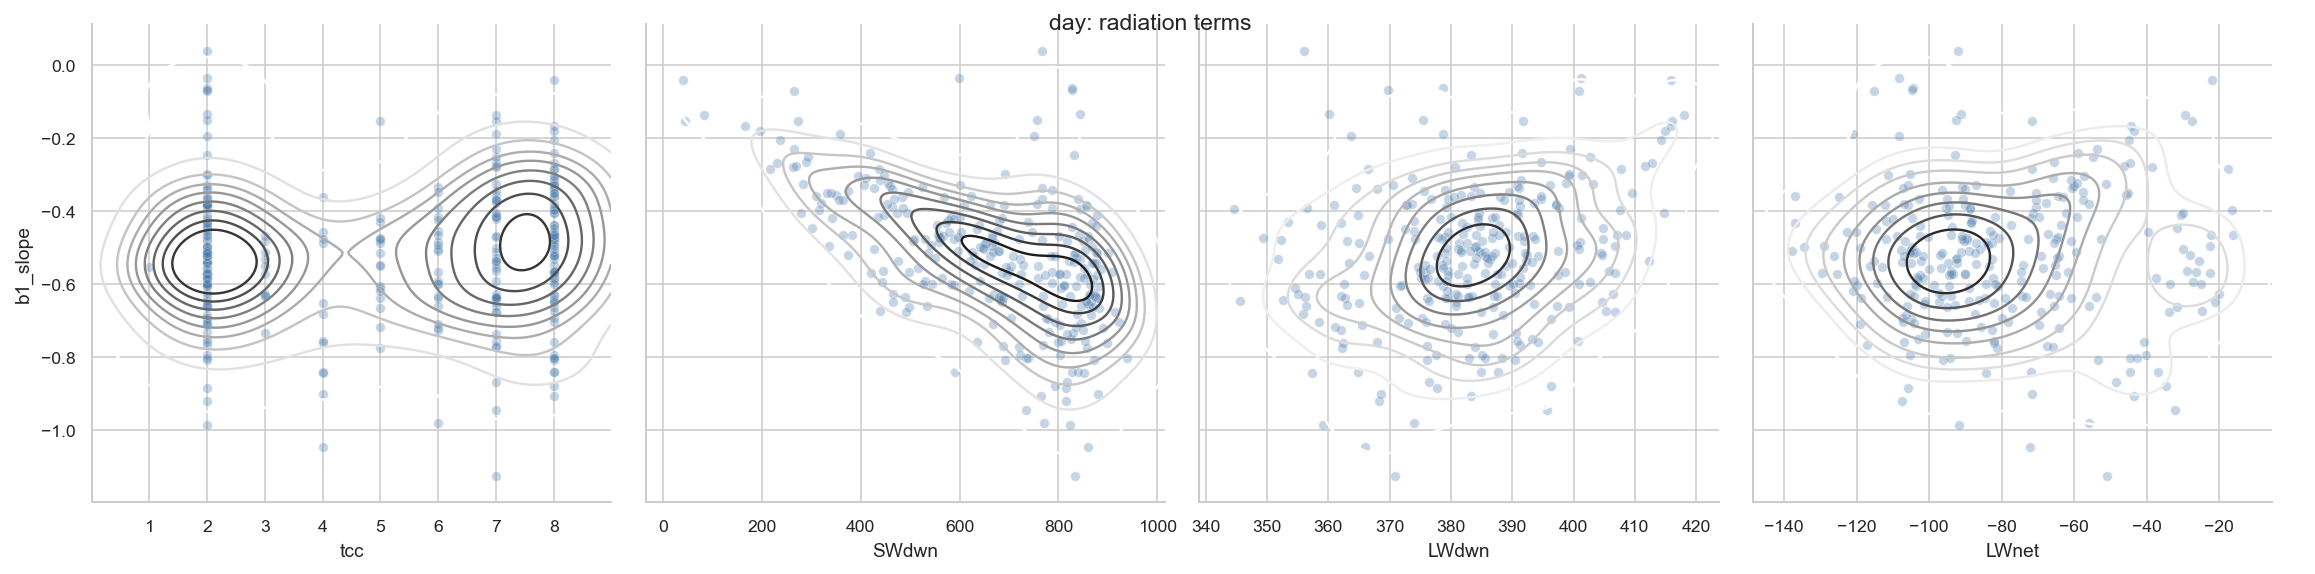

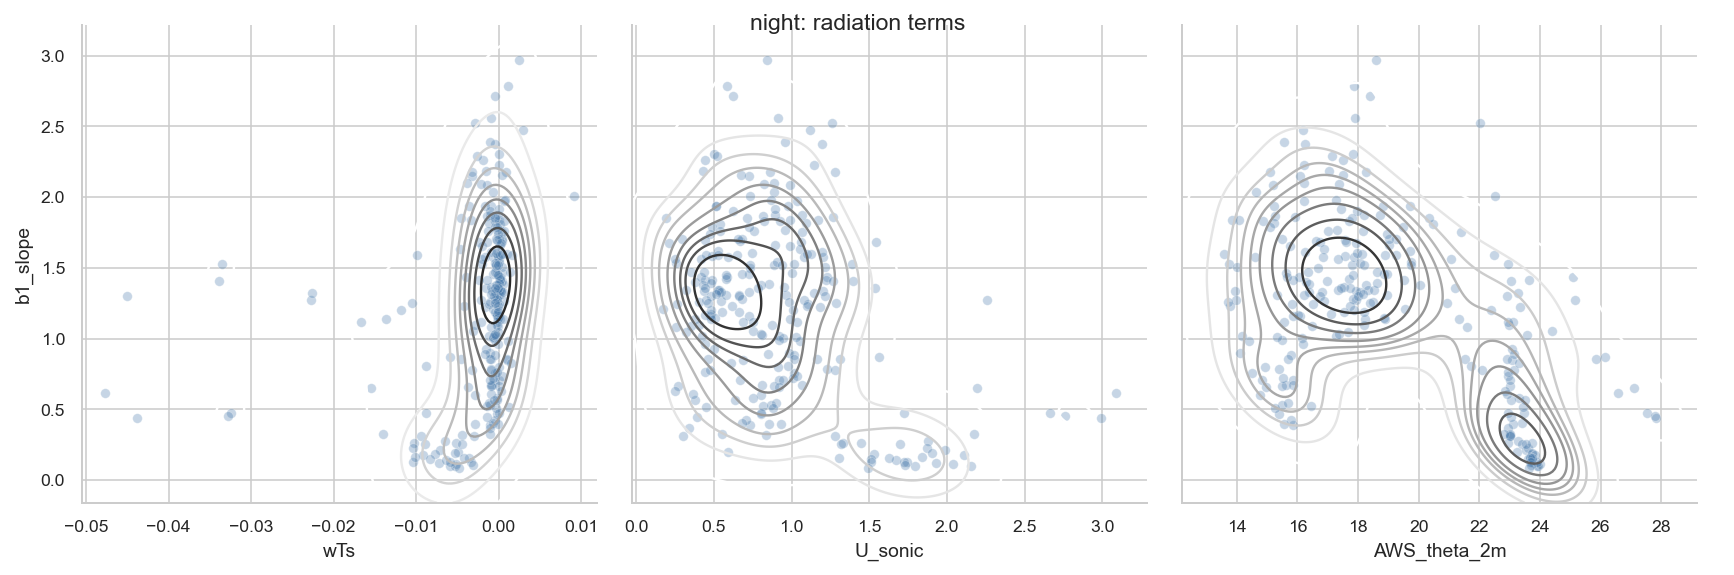

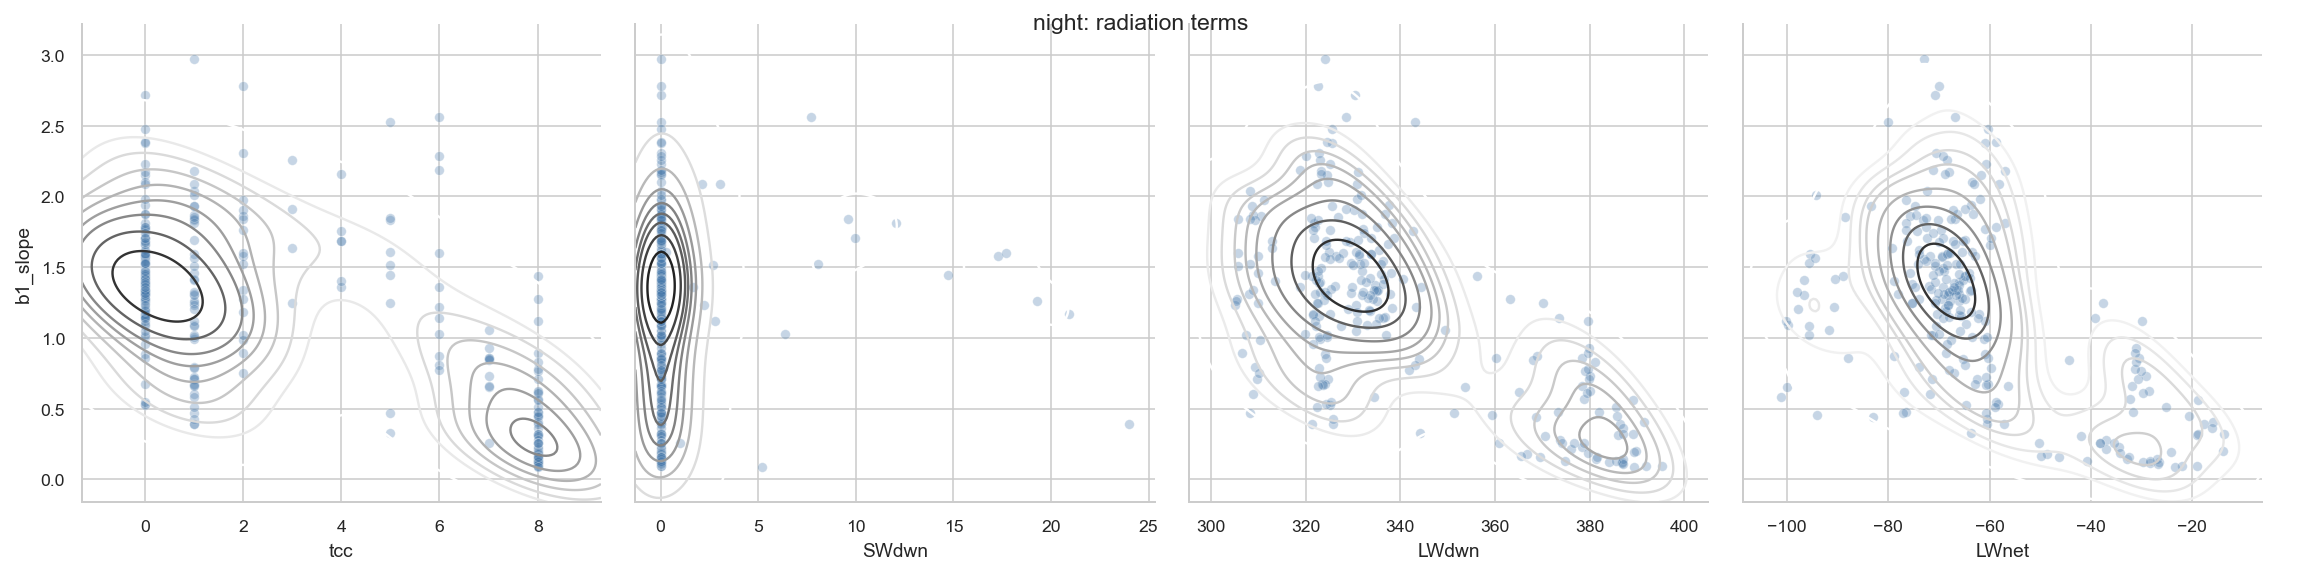

In [15]:
for interval in ['morning', 'evening', 'day', 'night']:
    # Turbulence terms
    g = sns.PairGrid(
        df_10min.where((df_10min.interval == interval)).loc['4m'],
        y_vars=["b1_slope"],
        x_vars=["wTs", "U_sonic", 'AWS_theta_2m'],
        height=4,
    )
    g.map(sns.kdeplot, cut=1, cmap="gray_r")
    g.map(sns.scatterplot, alpha=0.3)
    g.add_legend()
    plt.gcf().suptitle(interval + ': radiation terms')

    # Radiation terms
    g = sns.PairGrid(
        df_10min.where((df_10min.interval == interval)).loc['4m'],
        y_vars=["b1_slope"],
        x_vars=['tcc', 'SWdwn', 'LWdwn', 'LWnet'],
        height=4,
    )
    g.map(sns.kdeplot, cut=1, cmap="gray_r")
    g.map(sns.scatterplot, alpha=0.3)
    g.add_legend()
    plt.gcf().suptitle(interval + ': radiation terms')

There are obviously some covarying factors (as we should expect). Just to get a sense of those, we can do a large joint plot for the transition periods.

## 4.3 Joint plot to visualize all relationships

Look at just the transition periods for simplicity.

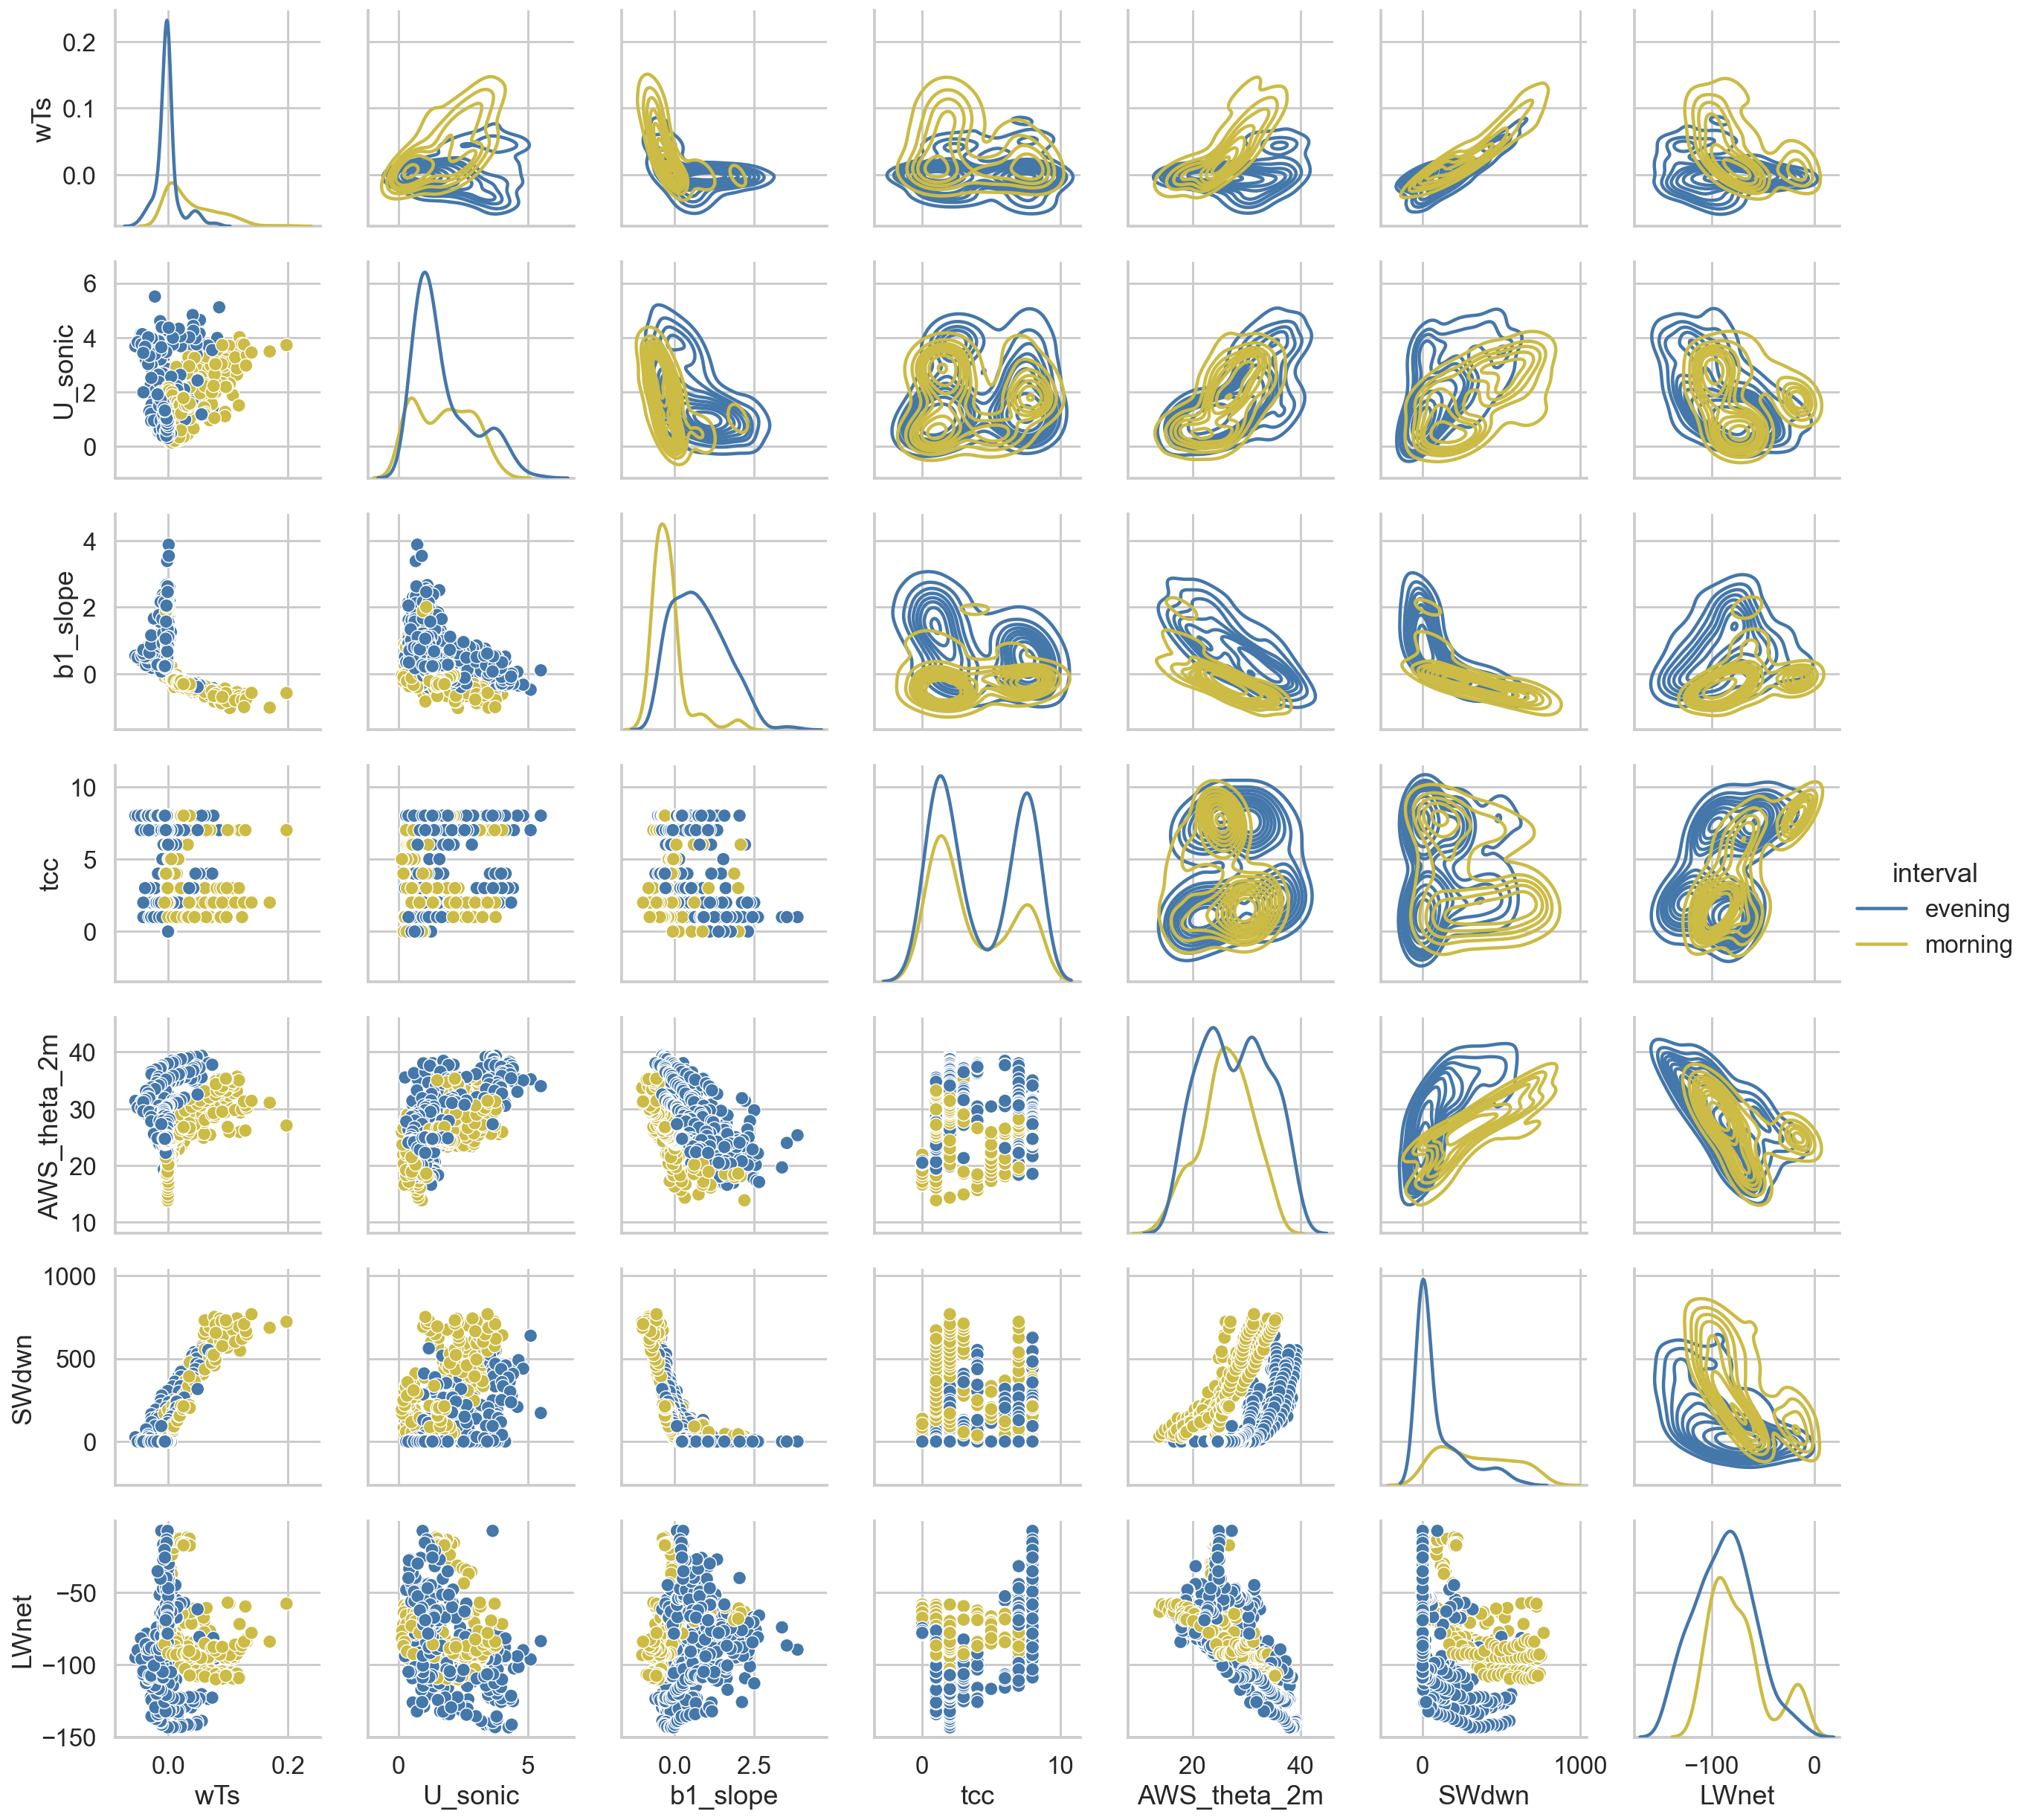

In [16]:
sns.set_context('talk')
grid = sns.PairGrid(
    df_10min.where((df_10min.interval == 'evening') | (df_10min.interval == 'morning')).loc['4m'],
    diag_sharey=False,
    hue='interval',
    vars=['wTs', 'U_sonic', 'b1_slope', 'tcc', 'AWS_theta_2m', 'SWdwn', 'LWnet'],
)

# Lower corner = scatter plots
glow = grid.map_lower(sns.scatterplot)
# Histograms on diagonal
gdiag = grid.map_diag(sns.kdeplot)
# Upper corner = KDE plots
gup = grid.map_upper(sns.kdeplot)
grid.add_legend()


To summarize some rather beefy figures, the log-linear slope tends to be more neutral when the wind speeds are larger, when the net longwave is very negative but some sunlight is present, when the difference between the AWS and tower at 2m is zero, when the potential temperature has not transitioned towards it day or night time values, and when the sensible heat flux is small (yay! That one is a necessity for believing the neutral boundary layer). However, there is a _lot_ of spread and co-varying parameters.

# 5. Dimensionality reduction

There are obvious clusters to make here. These clusters may be powerful for understanding the impact of typical meteorological observations on the stability, which is a major research question in boundary layer meteorology.

However, the very first step is to provide some dimensionality reduction.

In [17]:
vars_to_sample = ['b1_slope', 'SWdwn', 'LWdwn', 'wTs', 'U_sonic', 'AWS_theta_2m']

ds_analysis = ds_10min.sel(names='4m').where(~np.isnan(ds_10min['b1_slope']), drop=True)
sample = [ds_analysis[vts].values for vts in vars_to_sample]
sample = np.array(sample).T

In [18]:
# Apply the scaling (zero mean, variance=1)
sample_scld = StandardScaler().fit_transform(sample)

# PCA of the scaled data
pca = PCA(n_components=len(vars_to_sample))
sample_pca = pca.fit_transform(sample_scld)

# Percentage of variance explained for each components
print('explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio: [0.69085093 0.14545172 0.07695034 0.04497969 0.03694038 0.00482694]


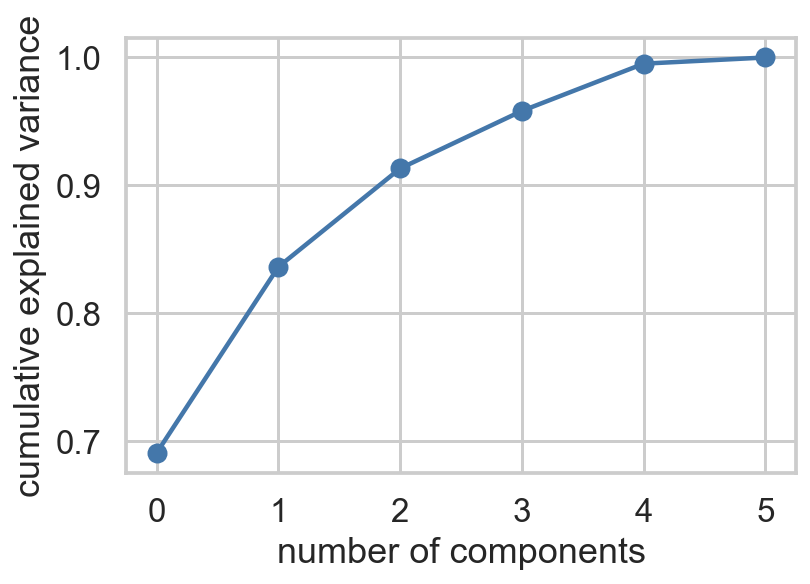

In [19]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

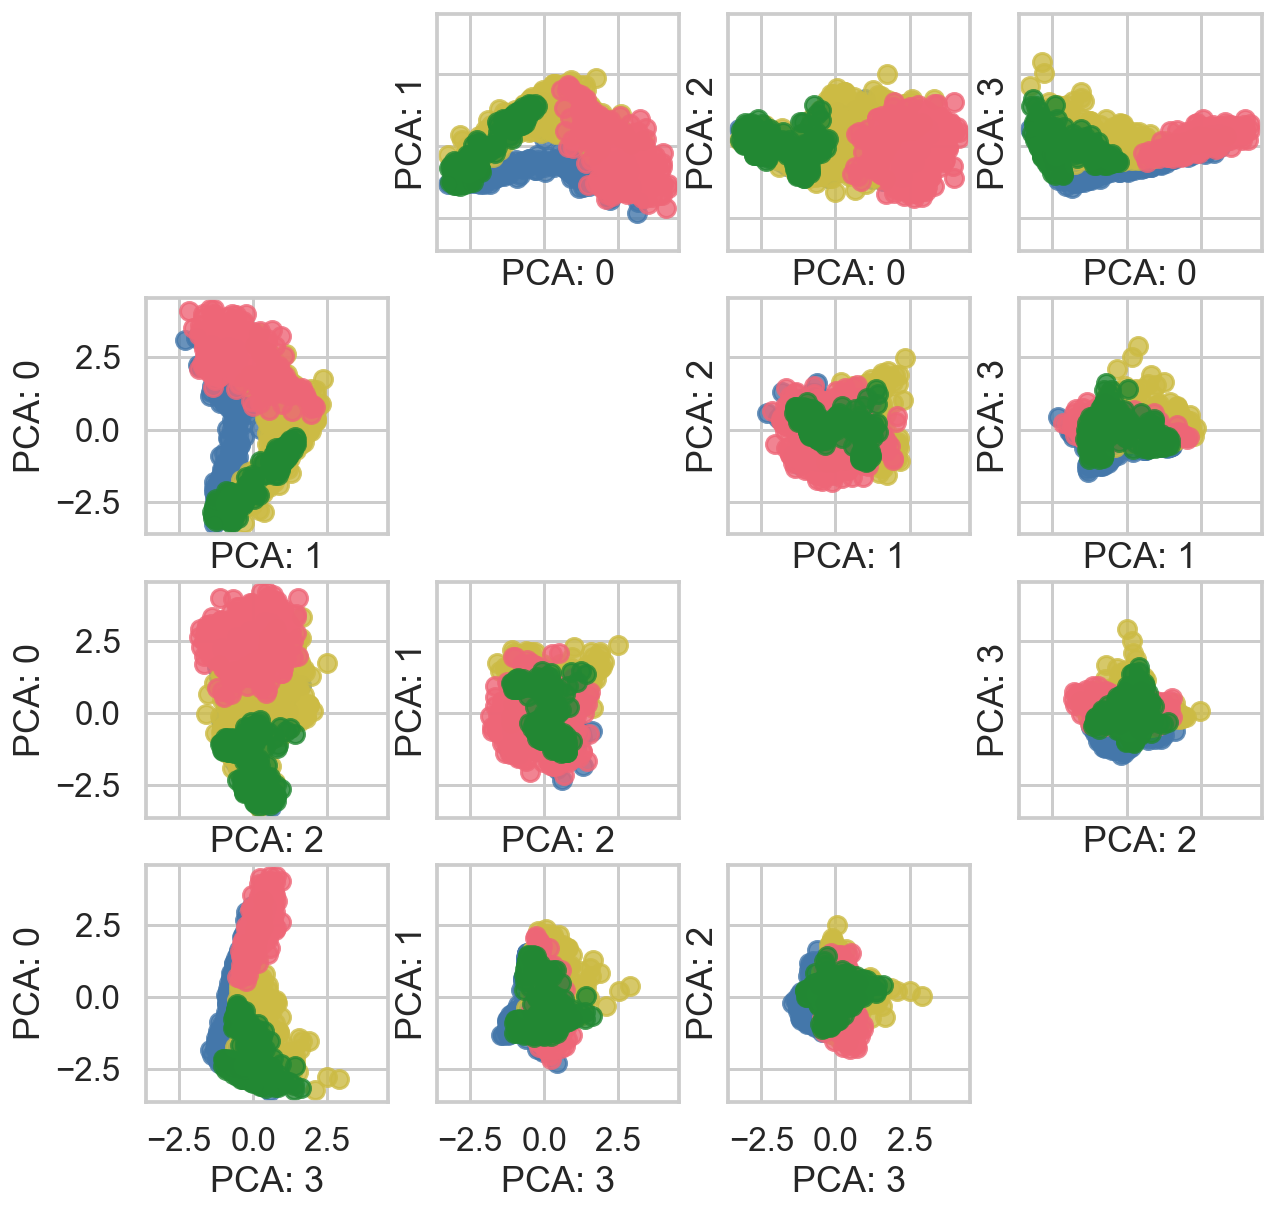

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)

for ax, (pca1, pca2) in zip(axes.flatten(), list(itertools.product(np.arange(0, 4), np.arange(0, 4)))):
    if pca1 == pca2:
        ax.axis('off')
        continue
    
    for nint, interval in enumerate(['morning', 'evening', 'day', 'night']):
        ind = np.flatnonzero(ds_analysis.interval == interval)
        ax.scatter(
            sample_pca[ind, pca1],
            sample_pca[ind, pca2],
            color=tol_bright_reorder[nint],
            alpha=.8,
        )
    ax.set_xlabel('PCA: {}'.format(pca1))
    ax.set_ylabel('PCA: {}'.format(pca2))

PCs 0 and 1 provide some obvious organization of the underlying data. The other PCs... not so much, which is not suprising given their relatively small amounts of variance explained.

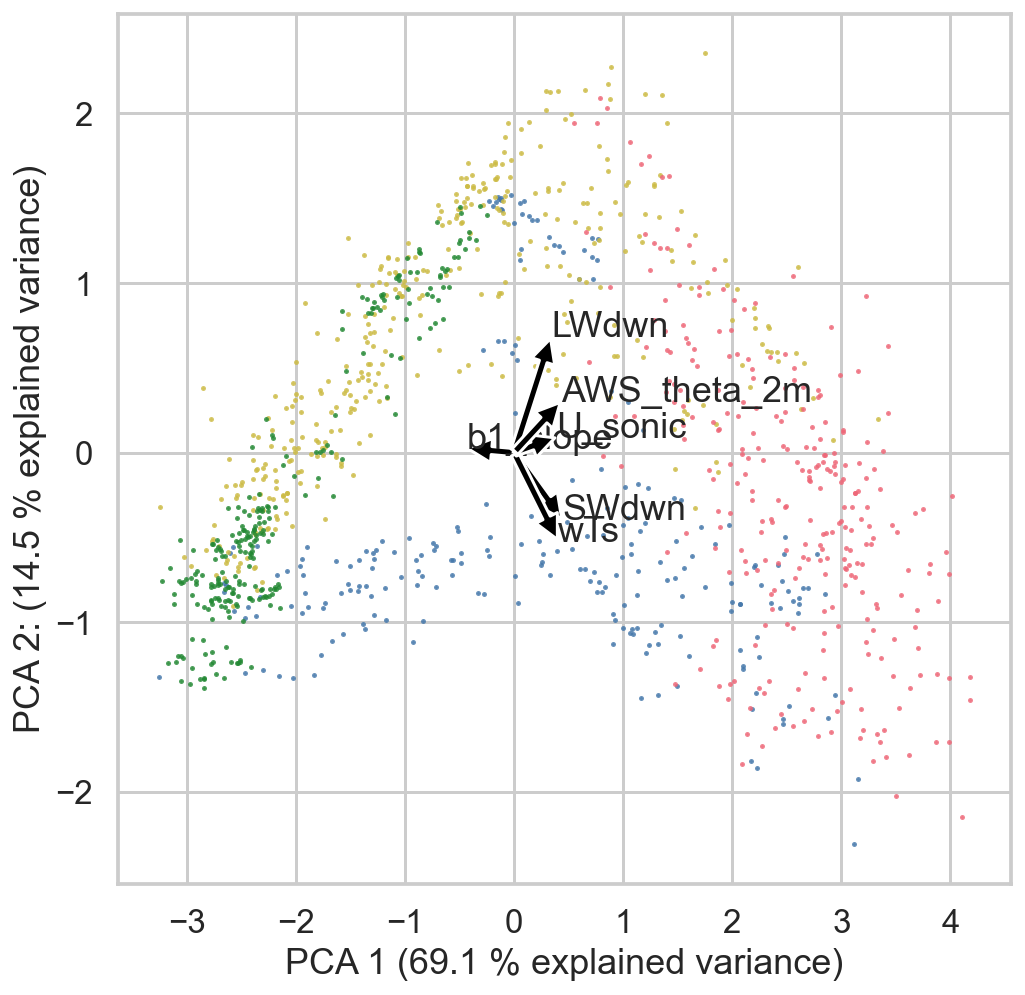

In [21]:
loadings = pca.components_.T
loadings_corr = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
for nint, interval in enumerate(['morning', 'evening', 'day', 'night']):
    ind = np.flatnonzero(ds_analysis.interval == interval)
    ax.scatter(
        sample_pca[ind, 0],
        sample_pca[ind, 1],
        1,
        color=tol_bright_reorder[nint],
        alpha=.8,
    )
ax.set_xlabel('PCA 1 ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('PCA 2: ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[1] * 100))

for nvar, vts in enumerate(vars_to_sample):
    ax.annotate(
        '',
        xytext=(0, 0), 
        xy=(loadings[nvar, 0], loadings[nvar, 1]),
        arrowprops=dict(
            facecolor='black',
            shrink=0.02,
        ),
    )
    
    ax.annotate(
        vts,
        xy=(0, 0), 
        xytext=(loadings[nvar, 0], loadings[nvar, 1]),
    )


The arrows and labels indicate the loadings of each variable for the two PCs. The majority of the variance can be explaiend by SWdwn (which strongly co-varies with the sensible heat flux, wTs) and LWdwn. Stability is largely independent of the other variables, which is whacky.

## 4.4 Conditionally sample according to time of day

The sunlight so strongly scales everything that the interesting behavior at night gets a bit washed out. Let's repeat the exercise with just the nighttime data.

explained variance ratio: [0.56173666 0.25843685 0.09756102 0.08226547]


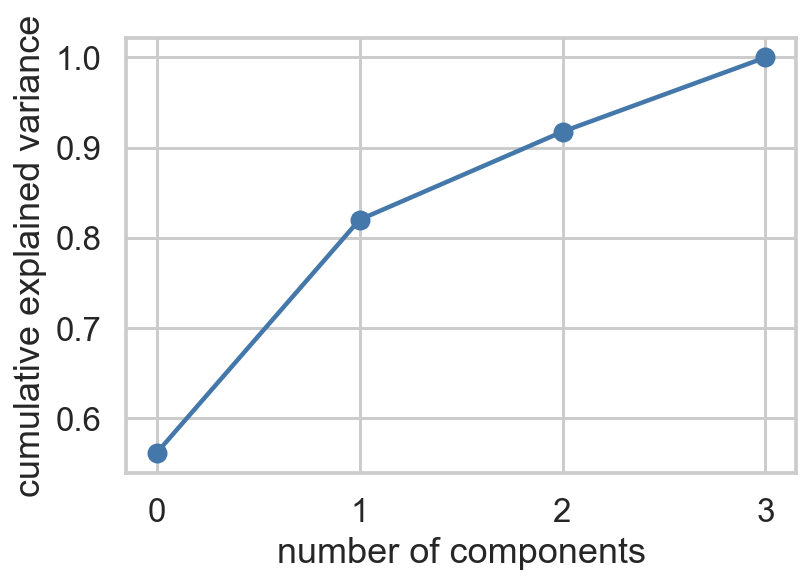

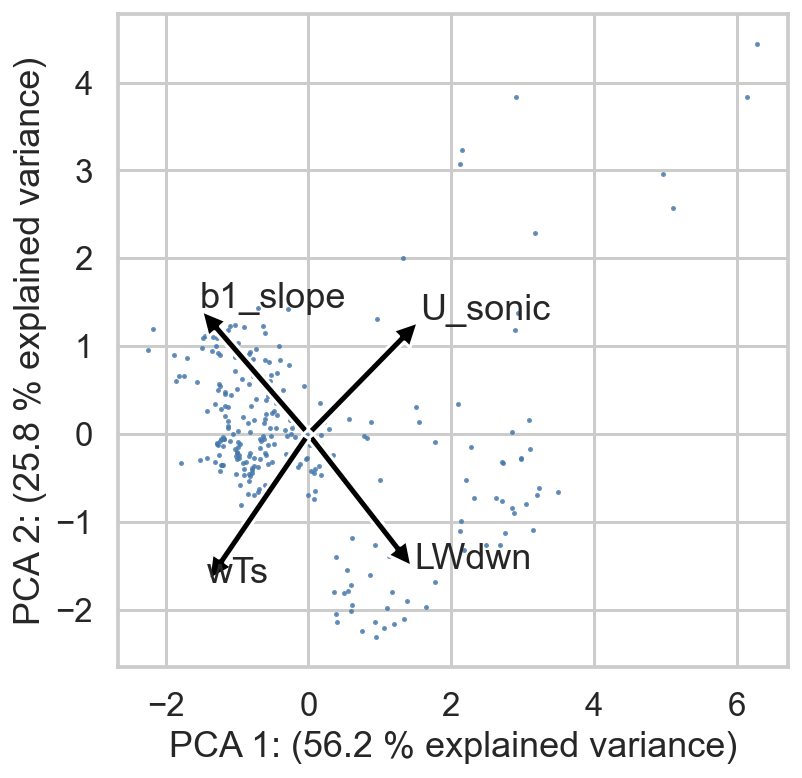

In [22]:
vars_to_sample = ['b1_slope', 'LWdwn', 'wTs', 'U_sonic',]# 'AWS_theta_2m']

ds_analysis = ds_10min.sel(names='4m').where(~np.isnan(ds_10min['b1_slope']), drop=True)
ds_analysis = ds_analysis.where(ds_10min.interval == 'night', drop=True)
sample = [ds_analysis[vts].values for vts in vars_to_sample]
sample = np.array(sample).T

# Apply the scaling (zero mean, variance=1)
sample_scld = StandardScaler().fit_transform(sample)

# PCA of the scaled data
pca = PCA(n_components=len(vars_to_sample))
sample_pca = pca.fit_transform(sample_scld)

# Percentage of variance explained for each components
print('explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# And the loadings biplot
loadings = pca.components_.T
loadings_corr = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
ax.scatter(
    sample_pca[:, 0],
    sample_pca[:, 1],
    1,
    alpha=.8,
)
ax.set_xlabel('PCA 1: ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('PCA 2: ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[1] * 100))

for nvar, vts in enumerate(vars_to_sample):
    ax.annotate(
        '',
        xytext=(0, 0), 
        # Scale the loadings for visual clarity
        xy=(loadings[nvar, 0] * 3, loadings[nvar, 1] * 3),
        arrowprops=dict(
            facecolor='black',
            shrink=0.02,
        ),
    )
    
    ax.annotate(
        vts,
        xy=(0, 0), 
        xytext=(loadings[nvar, 0] * 3, loadings[nvar, 1] * 3),
    )


At night the wind speed/sensible heat flux and Lwdwn/stability are orthogonal explanatory variables, which is really cool! The anti-correlation between LWdwn and stability is fantastic to see -- that fits our intuitive understanding perfectly.

Excluding the air temperature has no noticeable impact on the PCA results. This is also a good confirmation that our physical intuition is correct.

__Future directions__: 

- Perform an LDA to understand what causes the differences between the different day/night classifiers.
- ~~Apply a clustering classification to these data.~~
- ~~Correlate these clusters with disagreements between theory and observations.~~
- Predict periods of disagreement and their magnitude to better understand the missing factors in theory.

and most importantly

- Tie into the DTS surface array and the CWT based scale analysis!

# 5. Clustering with the PCA reduction

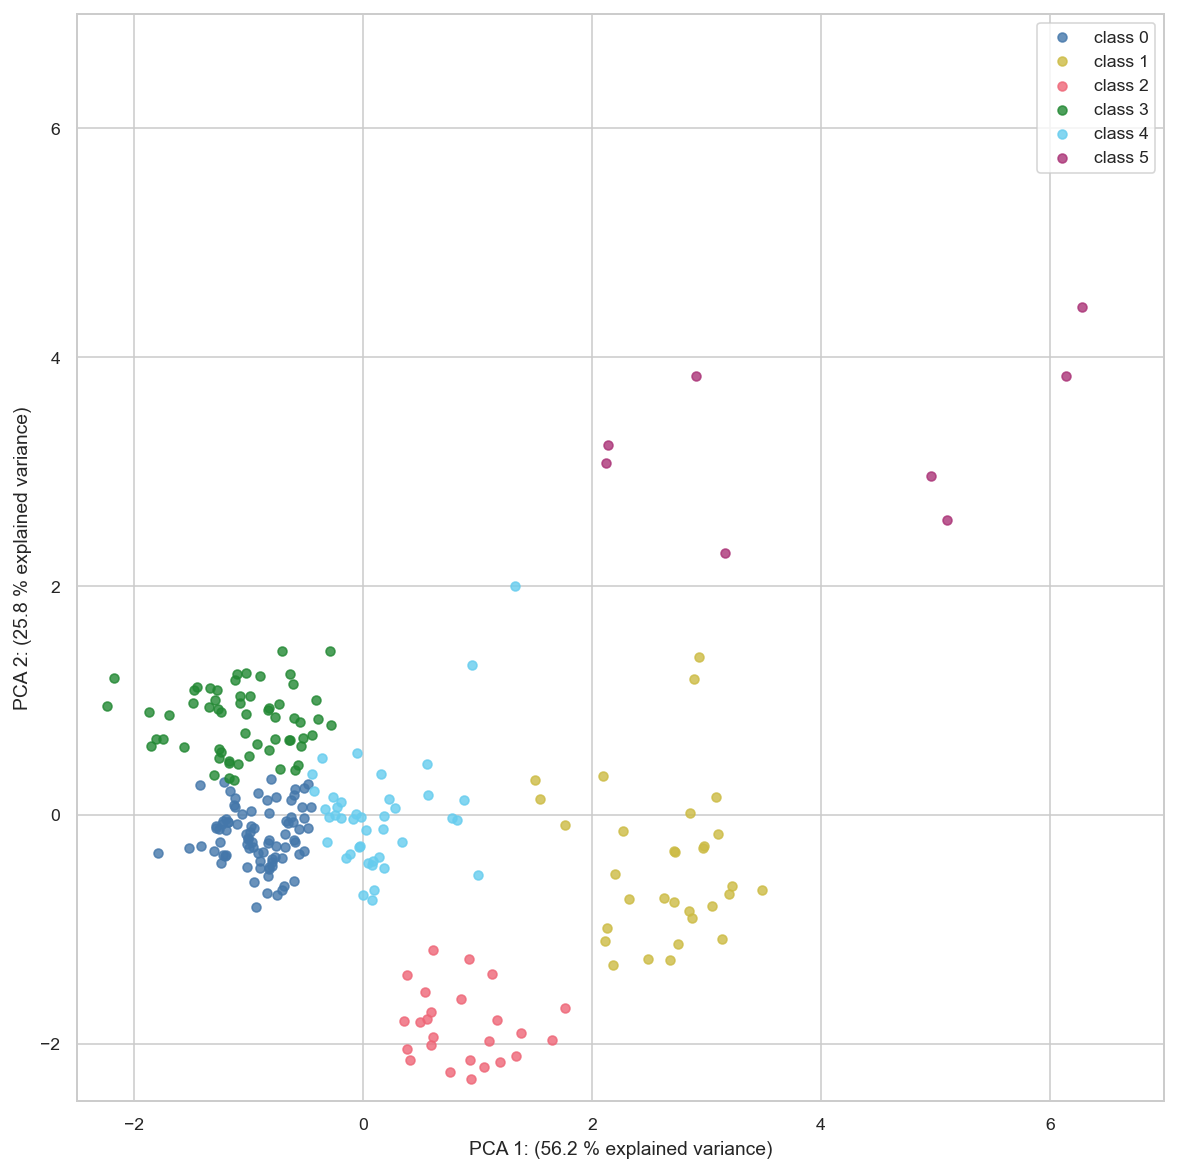

In [23]:
from sklearn.cluster import KMeans
sns.set_context('paper')

ncl = 6
y_pred = KMeans(
    n_clusters=ncl,
    random_state=0,
    n_init=10,
    init="k-means++",
).fit_predict(sample_pca[:, 0:2])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
scatter = []

# Create custom discrete colormap
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap',
#     sns.color_palette(tol_bright_reorder[0:6], as_cmap=True),
#     3,
# )

for n in np.unique(y_pred):
    sc = ax.scatter(
        sample_pca[y_pred == n, 0],
        sample_pca[y_pred == n, 1],
        20,
        alpha=.8,
        cmap=matplotlib.colors.to_rgb(tol_bright_reorder[n]),
        label='class {}'.format(n),
    )
    scatter.append(sc)
ax.set_xlabel('PCA 1: ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('PCA 2: ({:2.1f} % explained variance)'.format(pca.explained_variance_ratio_[1] * 100))
ax.set_aspect('equal', 'box')
ax.set_ylim(-2.5, 7)
ax.set_xlim(-2.5, 7)

# This only works when using a color map rather than discrete colors
# with the scatter command instead of just a single color per call
# like in the above loop.
# Produce a legend with the unique colors from the scatter command
# legend1 = ax.legend(
#     *scatter.legend_elements(),
#     loc="lower left",
#     title="Classes"
# )
# ax.add_artist(legend1)
ax.legend()

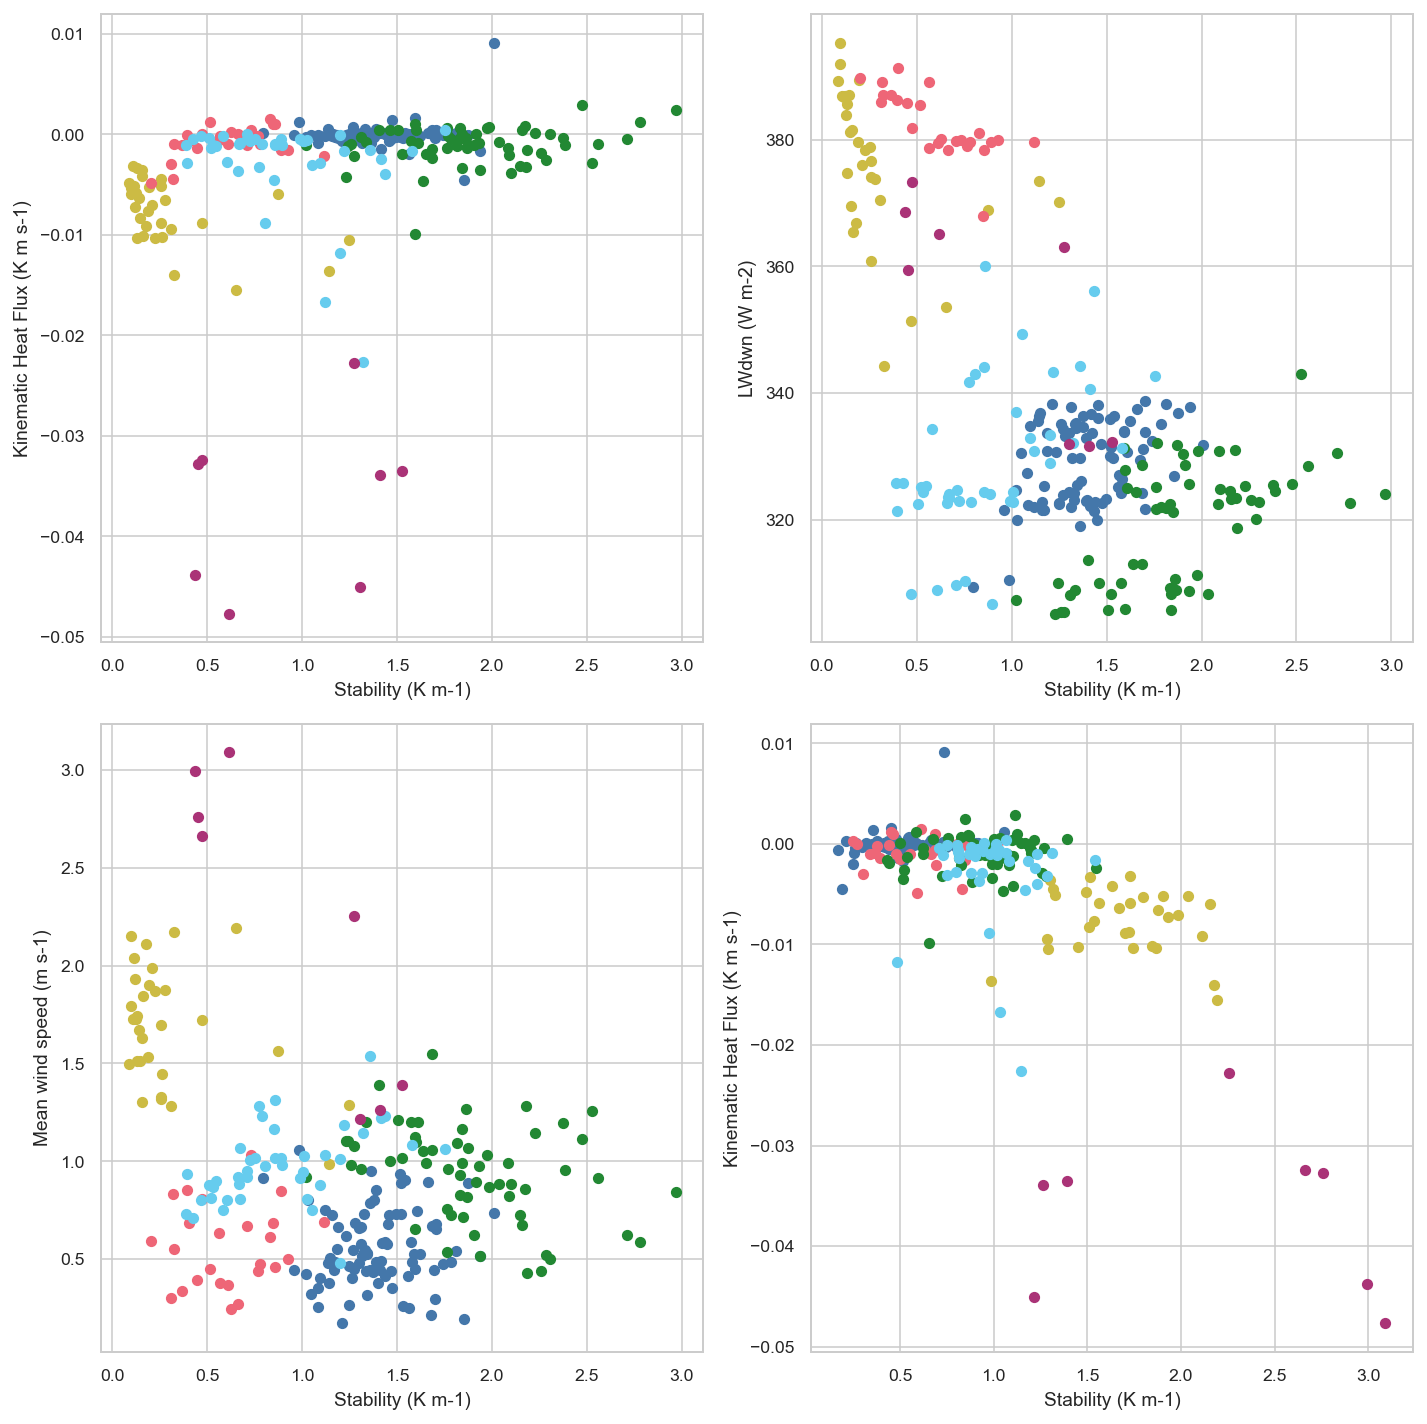

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for n in np.unique(y_pred):
    ds_plot = ds_analysis.where(ds_analysis.time[y_pred==n])
    axes[0].scatter(
        ds_plot.b1_slope.values,
        ds_plot.wTs.values,
        c=tol_bright_reorder[n]
    )

    axes[1].scatter(
        ds_plot.b1_slope.values,
        ds_plot.LWdwn.values,
        c=tol_bright_reorder[n]
    )
    
    axes[2].scatter(
        ds_plot.b1_slope.values,
        ds_plot.U_sonic.values,
        c=tol_bright_reorder[n]
    )
    
    axes[3].scatter(
        ds_plot.U_sonic.values,
        ds_plot.wTs.values,
        c=tol_bright_reorder[n]
    )
    
axes[0].set_ylabel('Kinematic Heat Flux (K m s-1)')
axes[0].set_xlabel('Stability (K m-1)')

axes[1].set_ylabel('LWdwn (W m-2)')
axes[1].set_xlabel('Stability (K m-1)')

axes[2].set_ylabel('Mean wind speed (m s-1)')
axes[2].set_xlabel('Stability (K m-1)')

axes[3].set_ylabel('Kinematic Heat Flux (K m s-1)')
axes[3].set_xlabel('Stability (K m-1)')

fig.tight_layout()

I didn't set out to do this, but it looks I may have accidentally built a useful predictor of particular types of events. Additional interpretation is not provided here.

# 6. LDA

This demonstration should be very straightforward for discriminating between the different day time classifications.

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


vars_to_sample = ['b1_slope', 'SWdwn', 'LWdwn', 'wTs', 'U_sonic', 'AWS_theta_2m']
ds_analysis = ds_10min.sel(names='4m').where(~np.isnan(ds_10min['b1_slope']), drop=True)
sample = [ds_analysis[vts].values for vts in vars_to_sample]
sample = np.array(sample).T
sample_scld = StandardScaler().fit_transform(sample)

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(sample, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [1138, 251]

In [ ]:
print(lda.explained_variance_ratio_)

In [ ]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y_pred,
    cmap='viridis',
    alpha=0.7,
    edgecolors='b',
    vmin=0,
    vmax=np.max(y_pred),
)

In [ ]:
plt.plot(y_pred)